# Notebook 5 : Word Embedding and Neural Network

### Introduction to Notebook: 

This notebook is an attempt at Neural networks, combined with an alternate approach to feature engineering the 2 text columns Description and Title, by using word embedding instead of Count Vectorizer.


## Table of Contents

[1 - Loading in the Lexvec word embedding model](#1)

[2 - Embedding the Description column](#2)

[3 - Embedding the Title column](#3)

[4 - Modeling IMDB Votes using Scikit Learn](#4)

[5 - Modeling IMDB Votes using Tensor Flow](#5)

[6 - Modeling IMDB Score using Tensor Flow](#6)

[7 - Conclusion](#7)

In [1]:
# Installing Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To try scaling the data in various ways
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# To try dimensionality reduction
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('data/data_for_word_embedding_modeling.csv')

In [3]:
df.head(2)

,id,title,type,description,release_year,runtime,seasons,imdb_score,imdb_votes,Superstars,...,prod_country_ph,prod_country_pl,prod_country_ru,prod_country_se,prod_country_th,prod_country_tr,prod_country_tw,prod_country_us,prod_country_xx,prod_country_za
0,tm84618,Taxi Driver,1,A mentally unstable Vietnam War veteran works ...,1976,114,0.0,8.2,808582.0,1,...,0,0,0,0,0,0,0,1,0,0
1,tm154986,Deliverance,1,Intent on seeing the Cahulawassee River before...,1972,109,0.0,7.7,107673.0,0,...,0,0,0,0,0,0,0,1,0,0


Looks like it got read in correctly. Now let's try the word embedding.

### 1

### Loading in the Lexvec word embedding model

In [3]:
import gensim

In [4]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    'data/lexvec-wikipedia-word-vectors', binary=False
)

Checking if this got done correctly - creating a heat map for the same word as in the notebook (turtle)

In [ ]:
turtle_vector = model["turtle"]
turtle_vector

array([ 1.68337e-01, -6.07340e-02, -1.13089e-01, -1.93138e-01,
        1.45056e-01,  3.44000e-03,  1.19876e-01,  4.71450e-02,
       -1.08717e-01, -1.36544e-01,  1.55300e-03,  1.27815e-01,
       -1.80432e-01,  1.85429e-01,  2.89327e-01, -2.06343e-01,
       -9.88010e-02, -2.28690e-02,  1.70756e-01,  4.59096e-01,
       -3.62160e-02,  4.58580e-02,  1.53405e-01, -1.99162e-01,
       -4.59473e-01,  3.37650e-02, -1.08214e-01,  9.95190e-02,
        1.27169e-01,  5.09100e-02, -2.82432e-01, -1.05779e-01,
       -1.03657e-01, -1.04305e-01, -1.39600e-03,  1.26930e-02,
       -2.21794e-01,  1.21372e-01, -3.52156e-01,  3.01924e-01,
        6.04080e-02, -2.15454e-01, -2.34705e-01,  1.02799e-01,
       -2.71996e-01, -2.12982e-01, -3.09037e-01, -4.44920e-02,
       -1.78825e-01, -6.63130e-02,  4.46350e-02, -3.18267e-01,
       -4.05890e-02, -2.58692e-01, -5.36960e-02,  2.40580e-01,
        2.24187e-01,  4.64624e-01,  1.42377e-01, -5.90000e-04,
        4.05554e-01,  7.75500e-03, -1.04347e-01, -3.582

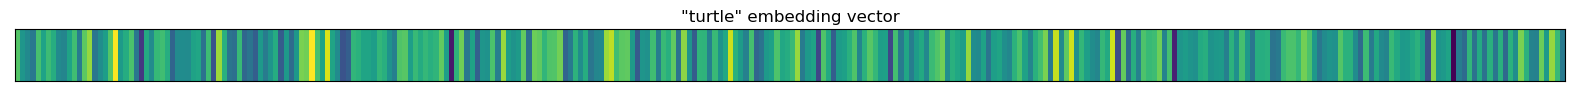

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(np.tile(model["turtle"], (10, 1)))
plt.xticks([])
plt.yticks([])
plt.title(f"\"turtle\" embedding vector")
plt.show()

### 2

### Embedding the `description` column

In [6]:
from gensim.utils import simple_preprocess

Checking if this is working fine - looking at the description for the first movie in the dataframe, Taxi Driver.

In [ ]:
tokenized = simple_preprocess(df['description'][0])

print(tokenized)

['mentally', 'unstable', 'vietnam', 'war', 'veteran', 'works', 'as', 'night', 'time', 'taxi', 'driver', 'in', 'new', 'york', 'city', 'where', 'the', 'perceived', 'decadence', 'and', 'sleaze', 'feed', 'his', 'urge', 'for', 'violent', 'action']


Seems to have worked correctly.

In [7]:
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

In [9]:
n = len(df)

In [10]:
descr_vect = pd.DataFrame(columns=range(300), index=range(0,n))

In [11]:
for i in range(0,n):
    descr_vect.loc[i] = sentence2vec(df['description'][i])

In [12]:
descr_vect.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
2158,0.036582,0.032198,-0.007443,-0.017023,-0.026217,0.024179,-0.039567,-0.008268,0.007583,0.04805,...,0.020128,-0.053325,-0.0582,-0.125772,-0.025454,-0.050099,0.052679,0.01869,-0.002775,-0.020458
3216,0.041665,0.051141,0.048943,-0.064907,-0.066236,0.016159,-0.039083,0.001737,-0.001867,-0.011619,...,-0.023317,-0.047854,-0.044965,-0.060307,-0.055428,0.014561,0.029082,0.003846,-0.025931,-0.030312
16506,0.04456,0.03678,0.04178,0.008937,-0.071094,0.055518,-0.068727,-0.071236,0.004741,-0.009214,...,-0.030026,-0.046401,-0.041129,-0.1103,-0.049097,-0.043043,0.031228,-0.003533,-0.006702,-0.016392
12972,0.012366,-0.001929,0.003485,-0.028967,-0.062216,0.013218,-0.047121,-0.035553,0.017753,0.039908,...,-0.014232,-0.016923,-0.02986,-0.088603,-0.048286,0.011057,0.095961,-0.003546,0.005559,-0.021131
15591,0.0481,0.038106,0.03584,-0.038637,-0.029915,0.037703,-0.037553,-0.010651,0.013986,0.011068,...,-0.009657,-0.01431,-0.01644,-0.063744,-0.075619,0.0003,0.061635,0.008101,-0.000952,-0.059071


In [13]:
new_column_names = [f'dv{i}' for i in range(1, 301)]

In [14]:
descr_vect.columns = new_column_names

In [15]:
descr_vect.sample(5)

,dv1,dv2,dv3,dv4,dv5,dv6,dv7,dv8,dv9,dv10,...,dv291,dv292,dv293,dv294,dv295,dv296,dv297,dv298,dv299,dv300
8206,0.023463,0.020932,0.018058,-0.043865,-0.047643,0.039793,-0.031772,-0.018827,0.027765,0.02525,...,0.026153,-0.053574,-0.013827,-0.054313,-0.044906,-0.018657,0.047687,0.022093,-0.034811,-0.009411
729,-0.008831,0.032645,0.042656,-0.033262,-0.025595,0.051453,-0.050186,-0.020239,0.005802,0.017739,...,-0.024026,0.008416,-0.022882,-0.078455,-0.06696,0.008728,0.091284,-0.063337,0.012251,-0.039543
10373,0.038263,-0.004907,0.041104,-0.065374,-0.071906,0.037439,-0.027142,-0.037981,0.01991,0.006706,...,0.024026,0.001166,-0.030163,-0.09042,-0.049992,0.034355,0.044013,-0.007574,0.013922,-0.029388
9833,0.047471,-0.01318,-0.011155,0.000402,-0.034889,0.011787,-0.039994,-0.00261,0.027179,0.056209,...,-0.013421,0.028766,-0.01411,-0.074724,-0.030311,0.008052,0.073031,0.00118,0.001833,0.007476
7102,0.064554,0.010909,0.008923,0.022747,-0.069933,0.036591,-0.029753,-0.061267,-0.032187,-0.01147,...,0.031132,0.005802,-0.038758,-0.061091,-0.077828,-0.027089,0.028061,-0.022079,-0.017212,-0.018915


In [17]:
descr_vect.shape

(16840, 300)

### 3

### Embedding the `titles` column

In [18]:
title_vect = pd.DataFrame(columns=range(300), index=range(0,n))

In [19]:
for i in range(0,n):
    title_vect.loc[i] = sentence2vec(df['title'][i])

In [20]:
title_column_names = [f'tv{i}' for i in range(1, 301)]

In [22]:
title_vect.columns = title_column_names
title_vect.tail(5)

,tv1,tv2,tv3,tv4,tv5,tv6,tv7,tv8,tv9,tv10,...,tv291,tv292,tv293,tv294,tv295,tv296,tv297,tv298,tv299,tv300
16835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16836,0.070372,-0.026427,0.037351,-0.061837,-0.025578,-0.008567,-0.075019,-0.031244,-0.060465,0.00726,...,-0.096398,-0.033591,-0.01974,-0.099657,-0.035509,0.09315,-0.045835,-0.023357,-0.067016,-0.003426
16837,0.078078,0.051633,-0.009849,0.023164,0.036062,0.084217,0.018601,-0.071427,0.018901,0.05638,...,-0.014627,-0.067086,-0.108349,-0.176916,0.146331,0.047881,0.019671,0.139235,-0.026572,0.016755
16838,0.028696,0.116732,-0.019205,0.048051,-0.030186,0.088906,-0.05428,-0.035945,0.069805,0.053608,...,0.086428,-0.001467,0.065887,0.039057,-0.030547,0.118104,-0.027732,-0.053983,-0.065594,-0.021546
16839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Interesting to note that the last row and 5th last row seems to be all 0 values for the title. Let's see what these titles are.

In [ ]:
df.tail()

,id,title,type,description,release_year,runtime,seasons,imdb_score,imdb_votes,Superstars,...,prod_country_ph,prod_country_pl,prod_country_ru,prod_country_se,prod_country_th,prod_country_tr,prod_country_tw,prod_country_us,prod_country_xx,prod_country_za
16835,tm1049635,Devineni,1,The film explores the life story of the famous...,2021,122,0.0,8.4,1188.0,0,...,0,0,0,0,0,0,0,0,0,0
16836,tm1078263,Good Boys for Life,1,"Toddrick Frank, a hustler, living his life unt...",2021,73,0.0,3.9,50.0,0,...,0,0,0,0,0,0,0,1,0,0
16837,tm822572,Gun and a Hotel Bible,1,"Based on the original play, Gun and a Hotel Bi...",2021,58,0.0,4.0,142.0,0,...,0,0,0,0,0,0,0,0,0,0
16838,tm510327,Lily Is Here,1,Dallas and heroin have one thing in common: Du...,2021,93,0.0,5.3,20.0,0,...,0,0,0,0,0,0,0,1,0,0
16839,tm1054116,Baikunth,1,"This story is about prevalent caste problem, e...",2021,72,0.0,8.4,49.0,0,...,0,0,0,0,0,0,0,0,0,0


It's both non-English words and likely proper nouns, which is why they've been vectorized as 0s.

In [23]:
df_processed = pd.concat([df, title_vect, descr_vect], axis=1)

In [24]:
df_processed.head(2)

,id,title,type,description,release_year,runtime,seasons,imdb_score,imdb_votes,Superstars,...,dv291,dv292,dv293,dv294,dv295,dv296,dv297,dv298,dv299,dv300
0,tm84618,Taxi Driver,1,A mentally unstable Vietnam War veteran works ...,1976,114,0.0,8.2,808582.0,1,...,0.011573,-0.055208,-0.073815,-0.10786,-0.043222,-0.020815,0.115895,0.011991,-0.015812,-0.040378
1,tm154986,Deliverance,1,Intent on seeing the Cahulawassee River before...,1972,109,0.0,7.7,107673.0,0,...,0.037781,0.001623,-0.040268,-0.078757,-0.034428,0.045272,0.043991,-0.035426,-0.006188,-0.039797


In [25]:
df_final = df_processed.drop(columns= ['id','title','description'])

In [26]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16840 entries, 0 to 16839
Columns: 672 entries, type to dv300
dtypes: float64(3), int64(69), object(600)
memory usage: 86.3+ MB


### 4

### Modeling IMDB Votes using Scikit Learn

For this we're going to start with a Neural Network model using scikit learn

In [27]:
#Taking the log of our target variable similar to what we did in Notebook 3
df_log = df_final.copy()

In [29]:
df_log['imdb_votes'] = np.log(df_final['imdb_votes'])

In [ ]:
#Saving the dataframe in case we just need to load it in to run the model

df_log.to_csv('data/output_of_word_embeddings.csv',index=False)

In [ ]:
df_log = pd.read_csv('output_of_word_embeddings.csv')

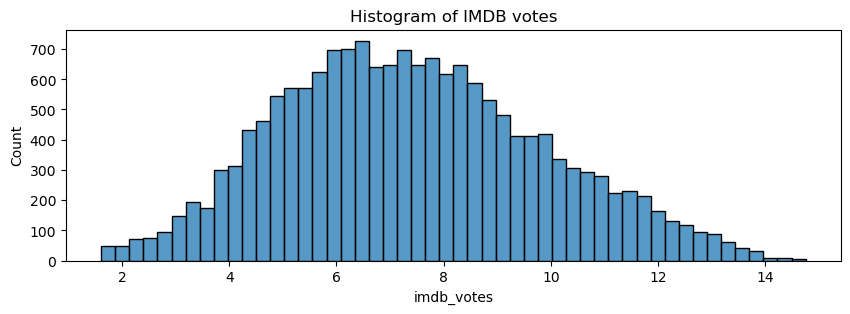

In [30]:
plt.figure(figsize=(10,3))
ax = sns.histplot(data=df_log, x='imdb_votes')
plt.title('Histogram of IMDB votes')
plt.show()

In [ ]:
X = df_log.drop(columns = ['imdb_score','imdb_votes'])
y = df_log['imdb_votes']

In [ ]:
X.head(2)

,type,release_year,runtime,seasons,Superstars,Allstars,Supporting,Other,oscar_acting,oscar_directing,...,dv291,dv292,dv293,dv294,dv295,dv296,dv297,dv298,dv299,dv300
0,1,1976,114,0.0,1,0,1,35,2,1,...,0.011573,-0.055208,-0.073815,-0.107860,-0.043222,-0.020815,0.115895,0.011991,-0.015812,-0.040378
1,1,1972,109,0.0,0,0,2,21,1,0,...,0.037781,0.001623,-0.040268,-0.078757,-0.034428,0.045272,0.043991,-0.035426,-0.006188,-0.039797


In [ ]:
y.head(2)

0    13.603037
1    11.586854
Name: imdb_votes, dtype: float64

In [ ]:
X.shape

(16840, 670)

In [ ]:
y.shape

(16840,)

In [ ]:
#Not using stratify=y as giving an error, plus this is a regression problem
#not a classification one

X_rem, X_test, y_rem, y_test = \
train_test_split(X, y, \
                 test_size=0.2, random_state=23)

X_train, X_val, y_train, y_val = \
train_test_split(X_rem, y_rem, \
                 test_size=0.2, random_state=23)

Further splitting into train and validation, if required.

In [ ]:
X_train, X_val, y_train, y_val = \
train_test_split(X_rem, y_rem, \
                 test_size=0.2, random_state=23)

In [ ]:
print(f'{X_train.shape},{y_train.shape},{X_val.shape},{y_val.shape}')

(10777, 670),(10777,),(2695, 670),(2695,)


We know neural networks benefit significantly from scaling, so doing that prior to modeling.

In [ ]:
scaler = StandardScaler().fit(X_train)

X_train_ss = scaler.transform(X_train)
X_val_ss = scaler.transform(X_val)

In [ ]:
print(f'{X_train_ss.shape},{X_val_ss.shape}')

(10777, 670),(2695, 670)


First using the standard neural network model within Scikit-Learn.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(50, 30), \
                   activation='relu', solver='adam', random_state=42, verbose=1)

In [ ]:
mlp.fit(X_train_ss, y_train)

Iteration 1, loss = 12.82226862
Iteration 2, loss = 2.77893002
Iteration 3, loss = 2.02043026
Iteration 4, loss = 1.68729808
Iteration 5, loss = 1.45499937
Iteration 6, loss = 1.27807453
Iteration 7, loss = 1.13606637
Iteration 8, loss = 1.01904744
Iteration 9, loss = 0.91869382
Iteration 10, loss = 0.83141876
Iteration 11, loss = 0.74669971
Iteration 12, loss = 0.67478756
Iteration 13, loss = 0.60752573
Iteration 14, loss = 0.55356578
Iteration 15, loss = 0.49949734
Iteration 16, loss = 0.45060647
Iteration 17, loss = 0.40512464
Iteration 18, loss = 0.37030445
Iteration 19, loss = 0.33212588
Iteration 20, loss = 0.30105917
Iteration 21, loss = 0.27238001
Iteration 22, loss = 0.24518508
Iteration 23, loss = 0.22324134
Iteration 24, loss = 0.19979515
Iteration 25, loss = 0.18172604
Iteration 26, loss = 0.16656036
Iteration 27, loss = 0.14874670
Iteration 28, loss = 0.13743864
Iteration 29, loss = 0.12236818
Iteration 30, loss = 0.11226199
Iteration 31, loss = 0.10299987
Iteration 32, lo

MLPRegressor(hidden_layer_sizes=(50, 30), random_state=42, verbose=1)

In [ ]:
# Make predictions on the validation set
y_pred = mlp.predict(X_val_ss)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 5.183736767147114
R^2 Score: 0.1446152002393556


The initial results on Scikit-Learn Neural Networks are not great. Let's try this again using Tensorflow.

### 5

### Modeling IMDB Votes using Tensor Flow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

In [ ]:
history = model.fit(X_train_ss, y_train, epochs=50, verbose=1)

Epoch 1/50
183/183 [==============================] - 2s 2ms/step - loss: 15.4368
Epoch 2/50
183/183 [==============================] - 0s 2ms/step - loss: 3.5192
Epoch 3/50
183/183 [==============================] - 0s 2ms/step - loss: 2.4910
Epoch 4/50
183/183 [==============================] - 0s 2ms/step - loss: 1.8898
Epoch 5/50
183/183 [==============================] - 1s 3ms/step - loss: 1.5323
Epoch 6/50
183/183 [==============================] - 1s 3ms/step - loss: 1.2381
Epoch 7/50
183/183 [==============================] - 1s 3ms/step - loss: 1.0410
Epoch 8/50
183/183 [==============================] - 1s 6ms/step - loss: 0.8443
Epoch 9/50
183/183 [==============================] - 1s 7ms/step - loss: 0.7251
Epoch 10/50
183/183 [==============================] - 1s 5ms/step - loss: 0.6157
Epoch 11/50
183/183 [==============================] - 1s 4ms/step - loss: 0.5206
Epoch 12/50
183/183 [==============================] - 1s 4ms/step - loss: 0.4320
Epoch 13/50
183/183 [===

In [ ]:
# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_val_ss, y_val, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred = model.predict(X_val_ss)

Train Loss: 0.1110
Test Loss: 4.0952
46/46 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import r2_score

r2_score(y_val,y_pred)

0.26956077209921236

Definitely an improvement vs Scikit Learn, but let's try to improve the R2 score further. Now trying a more powerful neural network buy adding more layers, and specifying a droput and L2 regularizers to reduce overfitting.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)



In [ ]:
history = model.fit(X_train_ss, y_train, epochs=100, verbose=1, batch_size=32,
    callbacks=[early_stopping])

Epoch 1/100
182/183 [============================>.] - ETA: 0s - loss: 0.8630

183/183 [==============================] - 1s 4ms/step - loss: 0.8623
Epoch 2/100
175/183 [===========================>..] - ETA: 0s - loss: 0.8485

183/183 [==============================] - 1s 4ms/step - loss: 0.8460
Epoch 3/100
181/183 [============================>.] - ETA: 0s - loss: 0.8601

183/183 [==============================] - 1s 4ms/step - loss: 0.8613
Epoch 4/100
178/183 [============================>.] - ETA: 0s - loss: 0.8659

183/183 [==============================] - 1s 4ms/step - loss: 0.8656
Epoch 5/100
173/183 [===========================>..] - ETA: 0s - loss: 0.8405

183/183 [==============================] - 1s 4ms/step - loss: 0.8393
Epoch 6/100
180/183 [============================>.] - ETA: 0s - loss: 0.8299

183/183 [==============================] - 1s 4ms/step - loss: 0.8268
Epoch 7/100
181/183 [============================>.] - ETA: 0s - loss: 0.8324

183/183 [==============================] - 1s 4ms/step - loss: 0.8315
Epoch 8/100
180/183 [============================>.] - ETA: 0s - loss: 0.8202

183/183 [==============================] - 1s 4ms/step - loss: 0.8181
Epoch 9/100
176/183 [===========================>..] - ETA: 0s - loss: 0.8128

183/183 [==============================] - 1s 6ms/step - loss: 0.8126
Epoch 10/100
178/183 [============================>.] - ETA: 0s - loss: 0.8312

183/183 [==============================] - 1s 7ms/step - loss: 0.8287
Epoch 11/100
182/183 [============================>.] - ETA: 0s - loss: 0.8183

183/183 [==============================] - 1s 6ms/step - loss: 0.8182
Epoch 12/100
176/183 [===========================>..] - ETA: 0s - loss: 0.8069

183/183 [==============================] - 1s 4ms/step - loss: 0.8076
Epoch 13/100
179/183 [============================>.] - ETA: 0s - loss: 0.8344

183/183 [==============================] - 1s 4ms/step - loss: 0.8347
Epoch 14/100
181/183 [============================>.] - ETA: 0s - loss: 0.8367

183/183 [==============================] - 1s 4ms/step - loss: 0.8377
Epoch 15/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7974

183/183 [==============================] - 1s 4ms/step - loss: 0.7977
Epoch 16/100
175/183 [===========================>..] - ETA: 0s - loss: 0.8019

183/183 [==============================] - 1s 4ms/step - loss: 0.8003
Epoch 17/100
173/183 [===========================>..] - ETA: 0s - loss: 0.7930

183/183 [==============================] - 1s 4ms/step - loss: 0.7970
Epoch 18/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7824

183/183 [==============================] - 1s 4ms/step - loss: 0.7823
Epoch 19/100
174/183 [===========================>..] - ETA: 0s - loss: 0.7744

183/183 [==============================] - 1s 4ms/step - loss: 0.7736
Epoch 20/100
179/183 [============================>.] - ETA: 0s - loss: 0.8040

183/183 [==============================] - 1s 4ms/step - loss: 0.8064
Epoch 21/100
175/183 [===========================>..] - ETA: 0s - loss: 0.8039

183/183 [==============================] - 1s 4ms/step - loss: 0.8047
Epoch 22/100
175/183 [===========================>..] - ETA: 0s - loss: 0.7740

183/183 [==============================] - 1s 5ms/step - loss: 0.7739
Epoch 23/100
182/183 [============================>.] - ETA: 0s - loss: 0.7828

183/183 [==============================] - 1s 4ms/step - loss: 0.7834
Epoch 24/100
180/183 [============================>.] - ETA: 0s - loss: 0.7831

183/183 [==============================] - 1s 6ms/step - loss: 0.7823
Epoch 25/100
181/183 [============================>.] - ETA: 0s - loss: 0.7715

183/183 [==============================] - 1s 6ms/step - loss: 0.7705
Epoch 26/100
180/183 [============================>.] - ETA: 0s - loss: 0.7932

183/183 [==============================] - 1s 7ms/step - loss: 0.7936
Epoch 27/100
177/183 [============================>.] - ETA: 0s - loss: 0.7912

183/183 [==============================] - 1s 5ms/step - loss: 0.7928
Epoch 28/100
172/183 [===========================>..] - ETA: 0s - loss: 0.7687

183/183 [==============================] - 1s 4ms/step - loss: 0.7698
Epoch 29/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7622

183/183 [==============================] - 1s 4ms/step - loss: 0.7688
Epoch 30/100
182/183 [============================>.] - ETA: 0s - loss: 0.7682

183/183 [==============================] - 1s 4ms/step - loss: 0.7689
Epoch 31/100
178/183 [============================>.] - ETA: 0s - loss: 0.7780

183/183 [==============================] - 1s 5ms/step - loss: 0.7772
Epoch 32/100
173/183 [===========================>..] - ETA: 0s - loss: 0.7527

183/183 [==============================] - 1s 5ms/step - loss: 0.7574
Epoch 33/100
177/183 [============================>.] - ETA: 0s - loss: 0.7509

183/183 [==============================] - 1s 5ms/step - loss: 0.7502
Epoch 34/100
173/183 [===========================>..] - ETA: 0s - loss: 0.7463

183/183 [==============================] - 1s 4ms/step - loss: 0.7448
Epoch 35/100
179/183 [============================>.] - ETA: 0s - loss: 0.7400

183/183 [==============================] - 1s 4ms/step - loss: 0.7418
Epoch 36/100
182/183 [============================>.] - ETA: 0s - loss: 0.7457

183/183 [==============================] - 1s 4ms/step - loss: 0.7459
Epoch 37/100
171/183 [===========================>..] - ETA: 0s - loss: 0.7477

183/183 [==============================] - 1s 4ms/step - loss: 0.7508
Epoch 38/100
171/183 [===========================>..] - ETA: 0s - loss: 0.7441

183/183 [==============================] - 1s 4ms/step - loss: 0.7449
Epoch 39/100
183/183 [==============================] - ETA: 0s - loss: 0.7527

183/183 [==============================] - 1s 6ms/step - loss: 0.7527
Epoch 40/100
177/183 [============================>.] - ETA: 0s - loss: 0.7514

183/183 [==============================] - 1s 6ms/step - loss: 0.7522
Epoch 41/100
178/183 [============================>.] - ETA: 0s - loss: 0.7744

183/183 [==============================] - 1s 6ms/step - loss: 0.7707
Epoch 42/100
171/183 [===========================>..] - ETA: 0s - loss: 0.7426

183/183 [==============================] - 1s 4ms/step - loss: 0.7411
Epoch 43/100
179/183 [============================>.] - ETA: 0s - loss: 0.7395

183/183 [==============================] - 1s 4ms/step - loss: 0.7424
Epoch 44/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7362

183/183 [==============================] - 1s 4ms/step - loss: 0.7352
Epoch 45/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7159

183/183 [==============================] - 1s 4ms/step - loss: 0.7172
Epoch 46/100
183/183 [==============================] - ETA: 0s - loss: 0.7152

183/183 [==============================] - 1s 4ms/step - loss: 0.7152
Epoch 47/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7205

183/183 [==============================] - 1s 5ms/step - loss: 0.7201
Epoch 48/100
178/183 [============================>.] - ETA: 0s - loss: 0.7331

183/183 [==============================] - 1s 4ms/step - loss: 0.7319
Epoch 49/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7546

183/183 [==============================] - 1s 4ms/step - loss: 0.7535
Epoch 50/100
179/183 [============================>.] - ETA: 0s - loss: 0.7196

183/183 [==============================] - 1s 4ms/step - loss: 0.7193
Epoch 51/100
172/183 [===========================>..] - ETA: 0s - loss: 0.7293

183/183 [==============================] - 1s 4ms/step - loss: 0.7262
Epoch 52/100
174/183 [===========================>..] - ETA: 0s - loss: 0.7194

183/183 [==============================] - 1s 4ms/step - loss: 0.7199
Epoch 53/100
171/183 [===========================>..] - ETA: 0s - loss: 0.7289

183/183 [==============================] - 1s 4ms/step - loss: 0.7243
Epoch 54/100
179/183 [============================>.] - ETA: 0s - loss: 0.7444

183/183 [==============================] - 1s 5ms/step - loss: 0.7449
Epoch 55/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7403

183/183 [==============================] - 1s 6ms/step - loss: 0.7405
Epoch 56/100
176/183 [===========================>..] - ETA: 0s - loss: 0.7569

183/183 [==============================] - 1s 6ms/step - loss: 0.7552
Epoch 57/100
179/183 [============================>.] - ETA: 0s - loss: 0.7300

183/183 [==============================] - 1s 5ms/step - loss: 0.7303
Epoch 58/100
177/183 [============================>.] - ETA: 0s - loss: 0.7167

183/183 [==============================] - 1s 4ms/step - loss: 0.7179
Epoch 59/100
182/183 [============================>.] - ETA: 0s - loss: 0.7213

183/183 [==============================] - 1s 4ms/step - loss: 0.7215
Epoch 60/100
178/183 [============================>.] - ETA: 0s - loss: 0.7301

183/183 [==============================] - 2s 10ms/step - loss: 0.7322
Epoch 61/100
181/183 [============================>.] - ETA: 0s - loss: 0.7196

183/183 [==============================] - 1s 5ms/step - loss: 0.7197
Epoch 62/100
183/183 [==============================] - ETA: 0s - loss: 0.7116

183/183 [==============================] - 1s 4ms/step - loss: 0.7116
Epoch 63/100
178/183 [============================>.] - ETA: 0s - loss: 0.7109

183/183 [==============================] - 1s 4ms/step - loss: 0.7118
Epoch 64/100
178/183 [============================>.] - ETA: 0s - loss: 0.6944

183/183 [==============================] - 1s 4ms/step - loss: 0.6958
Epoch 65/100
173/183 [===========================>..] - ETA: 0s - loss: 0.6826

183/183 [==============================] - 1s 5ms/step - loss: 0.6829
Epoch 66/100
172/183 [===========================>..] - ETA: 0s - loss: 0.6849

183/183 [==============================] - 1s 4ms/step - loss: 0.6853
Epoch 67/100
180/183 [============================>.] - ETA: 0s - loss: 0.7121

183/183 [==============================] - 1s 4ms/step - loss: 0.7118
Epoch 68/100
182/183 [============================>.] - ETA: 0s - loss: 0.6949

183/183 [==============================] - 1s 6ms/step - loss: 0.6946
Epoch 69/100
181/183 [============================>.] - ETA: 0s - loss: 0.7018

183/183 [==============================] - 1s 7ms/step - loss: 0.7016
Epoch 70/100
180/183 [============================>.] - ETA: 0s - loss: 0.6913

183/183 [==============================] - 1s 6ms/step - loss: 0.6909
Epoch 71/100
182/183 [============================>.] - ETA: 0s - loss: 0.7161

183/183 [==============================] - 1s 4ms/step - loss: 0.7151
Epoch 72/100
183/183 [==============================] - ETA: 0s - loss: 0.7363

183/183 [==============================] - 1s 4ms/step - loss: 0.7363
Epoch 73/100
183/183 [==============================] - ETA: 0s - loss: 0.6975

183/183 [==============================] - 1s 4ms/step - loss: 0.6975
Epoch 74/100
181/183 [============================>.] - ETA: 0s - loss: 0.7107

183/183 [==============================] - 1s 4ms/step - loss: 0.7106
Epoch 75/100
182/183 [============================>.] - ETA: 0s - loss: 0.7087

183/183 [==============================] - 1s 4ms/step - loss: 0.7102
Epoch 76/100
180/183 [============================>.] - ETA: 0s - loss: 0.7160

183/183 [==============================] - 1s 4ms/step - loss: 0.7159
Epoch 77/100
180/183 [============================>.] - ETA: 0s - loss: 0.7009

183/183 [==============================] - 1s 4ms/step - loss: 0.7012
Epoch 78/100
171/183 [===========================>..] - ETA: 0s - loss: 0.7140

183/183 [==============================] - 1s 4ms/step - loss: 0.7101
Epoch 79/100
178/183 [============================>.] - ETA: 0s - loss: 0.6918

183/183 [==============================] - 1s 4ms/step - loss: 0.6923
Epoch 80/100
182/183 [============================>.] - ETA: 0s - loss: 0.6959

183/183 [==============================] - 1s 4ms/step - loss: 0.6960
Epoch 81/100
177/183 [============================>.] - ETA: 0s - loss: 0.6873

183/183 [==============================] - 1s 5ms/step - loss: 0.6885
Epoch 82/100
181/183 [============================>.] - ETA: 0s - loss: 0.6949

183/183 [==============================] - 1s 5ms/step - loss: 0.6942
Epoch 83/100
183/183 [==============================] - ETA: 0s - loss: 0.7033

183/183 [==============================] - 1s 6ms/step - loss: 0.7033
Epoch 84/100
182/183 [============================>.] - ETA: 0s - loss: 0.7046

183/183 [==============================] - 1s 6ms/step - loss: 0.7039
Epoch 85/100
180/183 [============================>.] - ETA: 0s - loss: 0.6834

183/183 [==============================] - 1s 7ms/step - loss: 0.6827
Epoch 86/100
179/183 [============================>.] - ETA: 0s - loss: 0.6730

183/183 [==============================] - 1s 4ms/step - loss: 0.6723
Epoch 87/100
174/183 [===========================>..] - ETA: 0s - loss: 0.6904

183/183 [==============================] - 1s 4ms/step - loss: 0.6886
Epoch 88/100
183/183 [==============================] - ETA: 0s - loss: 0.6954

183/183 [==============================] - 1s 4ms/step - loss: 0.6954
Epoch 89/100
179/183 [============================>.] - ETA: 0s - loss: 0.6822

183/183 [==============================] - 1s 4ms/step - loss: 0.6840
Epoch 90/100
175/183 [===========================>..] - ETA: 0s - loss: 0.6714

183/183 [==============================] - 1s 4ms/step - loss: 0.6715
Epoch 91/100
175/183 [===========================>..] - ETA: 0s - loss: 0.6805

183/183 [==============================] - 1s 4ms/step - loss: 0.6790
Epoch 92/100
182/183 [============================>.] - ETA: 0s - loss: 0.7001

183/183 [==============================] - 1s 4ms/step - loss: 0.7001
Epoch 93/100
176/183 [===========================>..] - ETA: 0s - loss: 0.6801

183/183 [==============================] - 1s 4ms/step - loss: 0.6814
Epoch 94/100
183/183 [==============================] - ETA: 0s - loss: 0.6760

183/183 [==============================] - 1s 4ms/step - loss: 0.6760
Epoch 95/100
177/183 [============================>.] - ETA: 0s - loss: 0.6945

183/183 [==============================] - 1s 4ms/step - loss: 0.6932
Epoch 96/100
177/183 [============================>.] - ETA: 0s - loss: 0.6811

183/183 [==============================] - 1s 4ms/step - loss: 0.6810
Epoch 97/100
177/183 [============================>.] - ETA: 0s - loss: 0.6756

183/183 [==============================] - 1s 4ms/step - loss: 0.6755
Epoch 98/100
181/183 [============================>.] - ETA: 0s - loss: 0.6776

183/183 [==============================] - 1s 7ms/step - loss: 0.6777
Epoch 99/100
176/183 [===========================>..] - ETA: 0s - loss: 0.6474

183/183 [==============================] - 3s 16ms/step - loss: 0.6481
Epoch 100/100
173/183 [===========================>..] - ETA: 0s - loss: 0.6693

183/183 [==============================] - 1s 4ms/step - loss: 0.6709


In [ ]:

# Make predictions on the validation set
y_pred = model.predict(X_val_ss).flatten()

# Calculate the R2 score
r2 = r2_score(y_val, y_pred)

print(f'R^2 Score: {r2}')

46/46 [==============================] - 0s 3ms/step
R^2 Score: 0.48759360336581115


Trying one more time with a even more powerful neural network.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)


In [ ]:
# Train the model
history = model.fit(X_train_ss, y_train, epochs=100, verbose=1, batch_size=32)

Epoch 1/100
337/337 [==============================] - 4s 7ms/step - loss: 12.3255
Epoch 2/100
337/337 [==============================] - 3s 8ms/step - loss: 8.2557
Epoch 3/100
337/337 [==============================] - 3s 8ms/step - loss: 7.1843
Epoch 4/100
337/337 [==============================] - 2s 6ms/step - loss: 6.5003
Epoch 5/100
337/337 [==============================] - 2s 6ms/step - loss: 6.0769
Epoch 6/100
337/337 [==============================] - 2s 6ms/step - loss: 5.6576
Epoch 7/100
337/337 [==============================] - 2s 6ms/step - loss: 5.3220
Epoch 8/100
337/337 [==============================] - 3s 9ms/step - loss: 5.0478
Epoch 9/100
337/337 [==============================] - 2s 6ms/step - loss: 4.7954
Epoch 10/100
337/337 [==============================] - 2s 6ms/step - loss: 4.5513
Epoch 11/100
337/337 [==============================] - 2s 7ms/step - loss: 4.3412
Epoch 12/100
337/337 [==============================] - 2s 7ms/step - loss: 4.2632
Epoch 13/100

In [ ]:
# Cell 2: Evaluate the model and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_val_ss, y_val, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")


Train Loss: 1.4392
Test Loss: 3.4084


In [ ]:
result

3.408396005630493

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val_ss)

# Calculate the R2 score
r2 = r2_score(y_val, y_pred)

print(f'R^2 Score: {r2}')

85/85 [==============================] - 0s 4ms/step
R^2 Score: 0.513278343640384


This is our best score so far in the neural network modelling. We can add even more layers to try and improve the R2 score, though I'm not convinced that doing so will significantly increase the R2 score to get it close to what we were getting with XGBoost (0.607), so I'm going to stop here.

### 6

### Modeling IMDB Score with Tensor Flow

Running a neural network for a multi-class class classification is not as straightforward as a regression problem or a binary classification. So I'm going to try using the neural network in this instance for our original regression problem for IMDB score, without creating the 5 different classes.

In [ ]:
#The _log part here doesn't matter as we're dropping the IMDB votes column anyway
#This is just the file that we read in the csv from, after the word embedding

C = df_log.drop(columns = ['imdb_score','imdb_votes'])
d = df_log['imdb_score']

In [ ]:
d.head(2)

0    8.2
1    7.7
Name: imdb_score, dtype: float64

In [ ]:
# Split the data into remainder and testing sets
C_rem, C_test, d_rem, d_test = train_test_split(C, d, test_size=0.2, random_state=42)

# Split the remainder into training and validation sets
C_train, C_val, d_train, d_val = train_test_split(C_rem, d_rem, \
                                                    test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler().fit(C_train)

C_train_ss = scaler.transform(C_train)
C_val_ss = scaler.transform(C_val)

Using a neural network with the same configurations as our most recent iteration for the IMDB votes modeling.

In [ ]:
# random seeds for reproducibility
tf.random.set_seed(123)

# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))

# Declare the output layer
model.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

In [ ]:
# Train the model
history = model.fit(C_train_ss, d_train, epochs=100, verbose=1, batch_size=32)

Epoch 1/100
337/337 [==============================] - 6s 8ms/step - loss: 7.4627
Epoch 2/100
337/337 [==============================] - 2s 6ms/step - loss: 4.7839
Epoch 3/100
337/337 [==============================] - 2s 6ms/step - loss: 4.0341
Epoch 4/100
337/337 [==============================] - 2s 7ms/step - loss: 3.6859
Epoch 5/100
337/337 [==============================] - 4s 10ms/step - loss: 3.4401
Epoch 6/100
337/337 [==============================] - 3s 9ms/step - loss: 3.1662
Epoch 7/100
337/337 [==============================] - 3s 10ms/step - loss: 2.9845
Epoch 8/100
337/337 [==============================] - 2s 6ms/step - loss: 2.8419
Epoch 9/100
337/337 [==============================] - 4s 13ms/step - loss: 2.6465
Epoch 10/100
337/337 [==============================] - 4s 12ms/step - loss: 2.4949
Epoch 11/100
337/337 [==============================] - 5s 13ms/step - loss: 2.4261
Epoch 12/100
337/337 [==============================] - 4s 11ms/step - loss: 2.3228
Epoch 1

In [ ]:
# Cell 2: Evaluate the model and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(C_val_ss, d_val, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

# Make predictions on the validation set
d_pred = model.predict(C_val_ss)

# Calculate the R2 score
r2 = r2_score(d_val, d_pred)

print(f'R^2 Score: {r2}')

Train Loss: 0.5823
Test Loss: 1.3115
85/85 [==============================] - 0s 2ms/step
R^2 Score: 0.319510306657088


Similar to the IMDB votes modeling,  we can add even more layers to try and improve the R2 score. However this R2 score is still quite far away from the 0.514 score for the XGBoost model, and I'm not convinced that adding more complexity to the neural network model will increase the score that much. For that reason, stopping the modeling here.

### 7

### Conclusion

Using word embeddings was an interesting alternate approach to the Count Vectorizer, though ultimately the Description and Title columns are not huge predictors of either IMDB score or votes. We also tried neural networks on both IMDB Votes and Score but ultimately could not approach the results we were getting with XGBoost.